#Task Details:
1. Data cleaning including missing values, outliers and multi-collinearity.  
2. Describe your fraud detection model in elaboration.  
3. How did you select variables to be included in the model?  
4. Demonstrate the performance of the model by using best set of tools.  
5. What are the key factors that predict fraudulent customer?  
6. Do these factors make sense? If yes, How? If not, How not?  
7. What kind of prevention should be adopted while company update its infrastructure?
8. Assuming these actions have been implemented, how would you determine if they work?

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.feature_selection import mutual_info_regression

##Load and Inspect Data

In [8]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fraud.csv")

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.shape

(6362620, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
#Renaming column names for convenience
df.columns=["Transaction_Hours","Type","Transaction_Amt","Sender","Sender_Bal_b4","Sender_Bal_After","Receiver","Receiver_Bal_b4","Receiver_Bal_After","isFraud","isFraud_Flage"]

In [ ]:
df.head()

,Transaction_Hours,Type,Transaction_Amt,Sender,Sender_Bal_b4,Sender_Bal_After,Receiver,Receiver_Bal_b4,Receiver_Bal_After,isFraud,isFraud_Flage
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data Imbalance Check

In [82]:
df["isFraud"].value_counts()

,count
isFraud,
0,6354407
1,8213


In [ ]:
print('Genuine:', round(df['isFraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds:', round(df['isFraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Genuine: 99.87 % of the dataset
Frauds: 0.13 % of the dataset


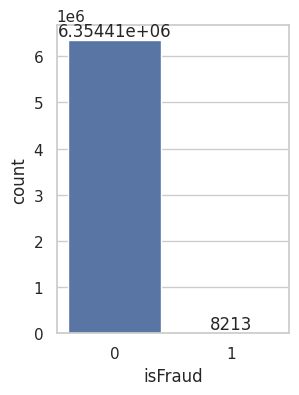

In [ ]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='isFraud',data=df)#,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

#1.Data cleaning including missing values, outliers and multi-collinearity.

In [ ]:
# Missing Values
df.isnull().sum()

,0
Transaction_Hours,0
Type,0
Transaction_Amt,0
Sender,0
Sender_Bal_b4,0
Sender_Bal_After,0
Receiver,0
Receiver_Bal_b4,0
Receiver_Bal_After,0
isFraud,0


In [10]:
#Outlier Detection
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features

['Transaction_Hours',
 'Transaction_Amt',
 'Sender_Bal_b4',
 'Sender_Bal_After',
 'Receiver_Bal_b4',
 'Receiver_Bal_After',
 'isFraud',
 'isFraud_Flage']

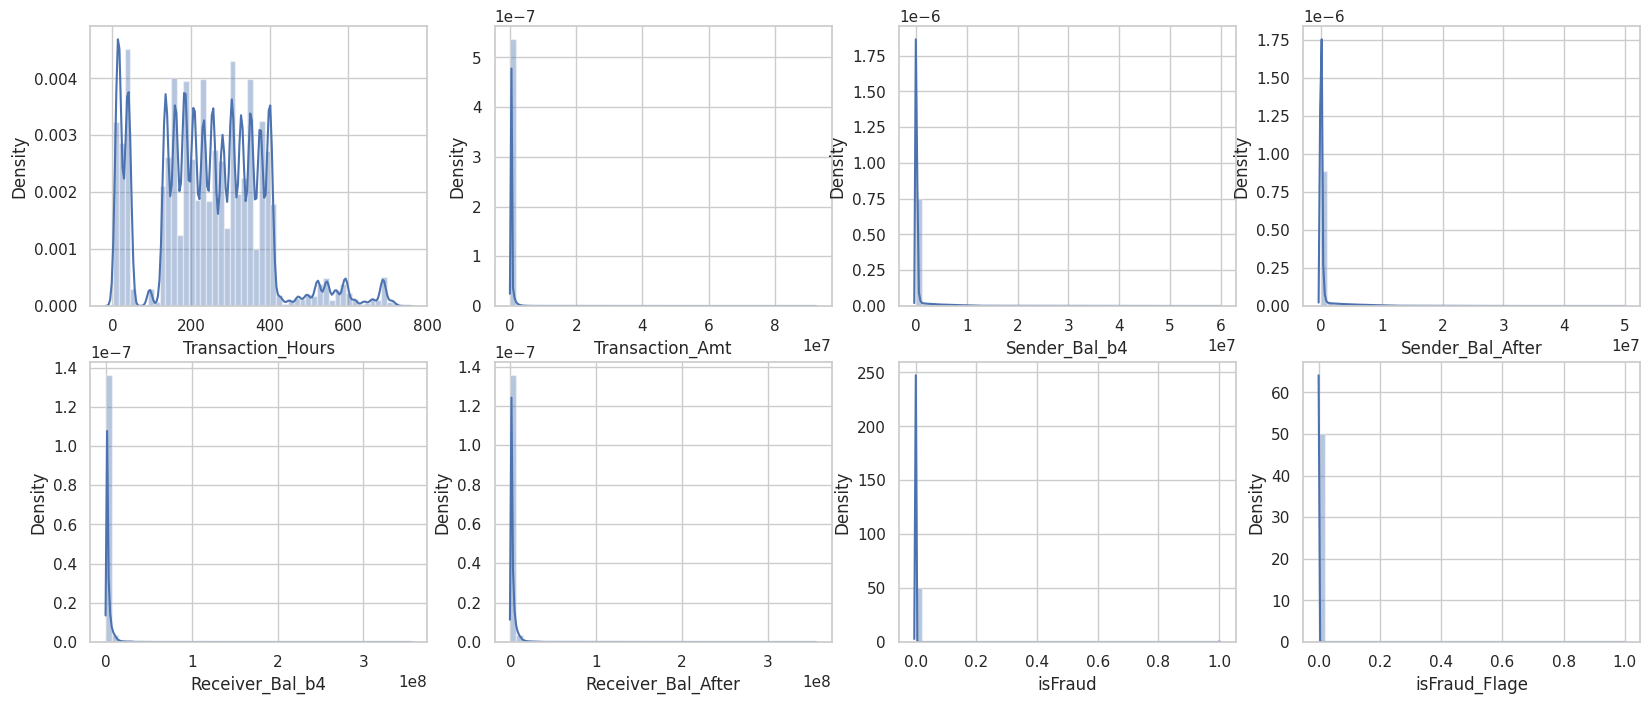

In [ ]:
#Plotting all numerical features for distribution check
plt.figure(figsize=(20,8))
warnings.filterwarnings("ignore")

for features in numerical_features:
  plt.subplot(2,4,numerical_features.index(features)+1)
  sns.distplot(df[features])
plt.show()

In [11]:
#dropping irrelevant columns
df=df.drop(["isFraud_Flage","Sender","Receiver"],axis=1)

In [ ]:
df.columns

Index(['Transaction_Hours', 'Type', 'Transaction_Amt', 'Sender_Bal_b4',
       'Sender_Bal_After', 'Receiver_Bal_b4', 'Receiver_Bal_After', 'isFraud'],
      dtype='object')

In [12]:
#Numerical Features except Dependent Feature
num_features=numerical_features[:-2]
num_features

['Transaction_Hours',
 'Transaction_Amt',
 'Sender_Bal_b4',
 'Sender_Bal_After',
 'Receiver_Bal_b4',
 'Receiver_Bal_After']

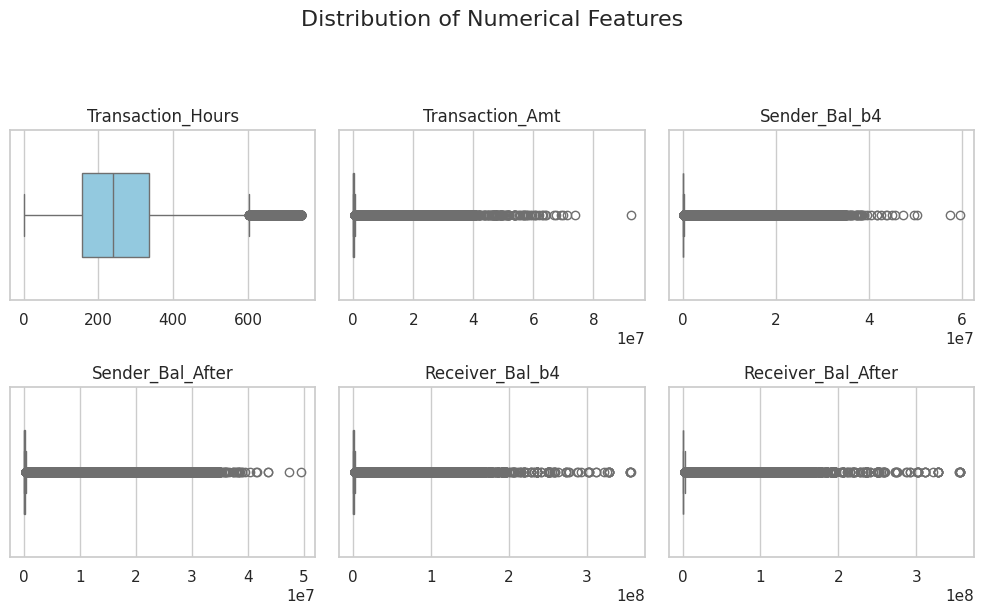

In [ ]:
import math
#Number of numerical cols
num_columns=len(num_features)

#Calculate the number of rows and columns needed for the  subplots
num_cols=3
num_rows=math.ceil(num_columns/num_cols)#Calculate rows needed

plt.figure(figsize=(10,num_rows*3))

sns.set_palette("husl")
sns.set(style="whitegrid")

for i,col in enumerate(num_features,1):
    plt.subplot(num_rows,num_cols,i)
    sns.boxplot(x=df[col],color="skyblue",width=0.5)
    plt.title(col)
    plt.xlabel("")

plt.suptitle("Distribution of Numerical Features",y=1.02,fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

In [13]:
#Applying Capping on Each Numerical Feature
def outliers_capping(df,features):


    new_df_cap=df.copy()
    # iterating over features(columns)
    for col in features:
      #Finding the IQR
      percentile25=df[col].quantile(0.25)
      percentile75=df[col].quantile(0.75)
      iqr=percentile75-percentile25
      upper_limit=percentile75+1.5*iqr
      lower_limit=percentile25-1.5*iqr

      new_df_cap[col]=np.where(
      new_df_cap[col] > upper_limit,
      upper_limit,
      np.where(
           new_df_cap[col] < lower_limit,
           lower_limit,
           new_df_cap[col]
         )
        )

    return new_df_cap

In [14]:
df_updated=outliers_capping(df,num_features)
df_updated

,Transaction_Hours,Type,Transaction_Amt,Sender_Bal_b4,Sender_Bal_After,Receiver_Bal_b4,Receiver_Bal_After,isFraud
0,1.0,PAYMENT,9839.64000,170136.0000,160296.36,0.000000e+00,0.000,0
1,1.0,PAYMENT,1864.28000,21249.0000,19384.72,0.000000e+00,0.000,0
2,1.0,TRANSFER,181.00000,181.0000,0.00,0.000000e+00,0.000,1
3,1.0,CASH_OUT,181.00000,181.0000,0.00,2.118200e+04,0.000,1
4,1.0,PAYMENT,11668.14000,41554.0000,29885.86,0.000000e+00,0.000,0
...,...,...,...,...,...,...,...,...
6362615,603.5,CASH_OUT,339682.13000,268287.9375,0.00,0.000000e+00,339682.130,1
6362616,603.5,TRANSFER,501719.33875,268287.9375,0.00,0.000000e+00,0.000,1
6362617,603.5,CASH_OUT,501719.33875,268287.9375,0.00,6.848884e+04,2779773.125,1
6362618,603.5,TRANSFER,501719.33875,268287.9375,0.00,0.000000e+00,0.000,1


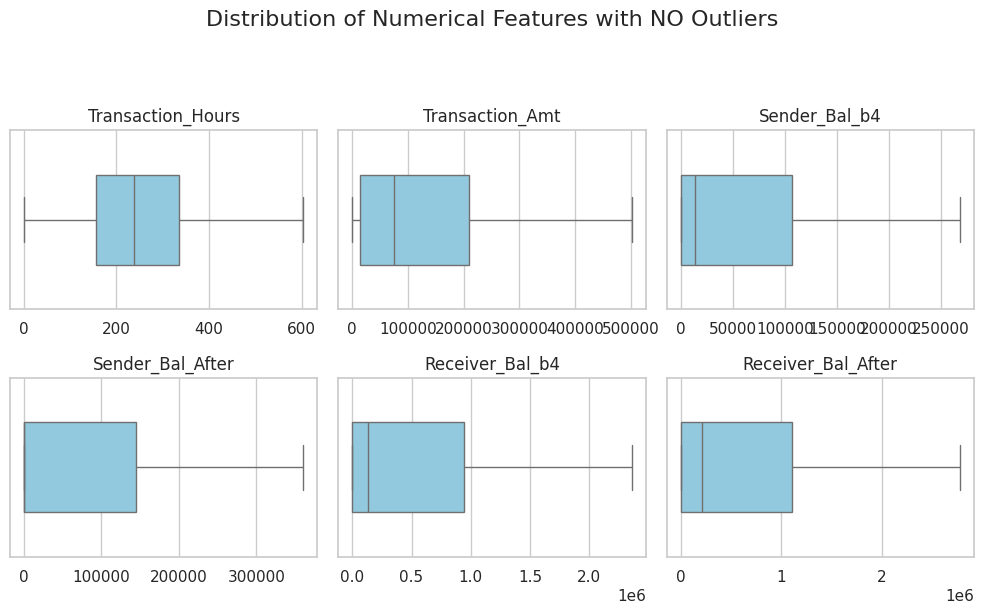

In [115]:
import math
#Number of numerical cols
num_columns=len(num_features)

#Calculate the number of rows and columns needed for the  subplots
num_cols=3
num_rows=math.ceil(num_columns/num_cols)#Calculate rows needed

plt.figure(figsize=(10,num_rows*3))

sns.set_palette("husl")
sns.set(style="whitegrid")

for i,col in enumerate(num_features,1):
    plt.subplot(num_rows,num_cols,i)
    sns.boxplot(x=df_updated[col],color="skyblue",width=0.5)
    plt.title(col)
    plt.xlabel("")

plt.suptitle("Distribution of Numerical Features with NO Outliers",y=1.02,fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

#Multi-Collinearity
Correlation Analysis: Use correlation matrices or heatmaps to identify relationships between variables. Highly correlated variables may contain redundant information and could be removed.

In [15]:
#Encoding Categorical Variables
le=LabelEncoder()
df_updated["Type"]=le.fit_transform(df["Type"])

In [ ]:
df_updated

,Transaction_Hours,Type,Transaction_Amt,Sender_Bal_b4,Sender_Bal_After,Receiver_Bal_b4,Receiver_Bal_After,isFraud
0,1.0,3,9839.64000,170136.0000,160296.36,0.000000e+00,0.000,0
1,1.0,3,1864.28000,21249.0000,19384.72,0.000000e+00,0.000,0
2,1.0,4,181.00000,181.0000,0.00,0.000000e+00,0.000,1
3,1.0,1,181.00000,181.0000,0.00,2.118200e+04,0.000,1
4,1.0,3,11668.14000,41554.0000,29885.86,0.000000e+00,0.000,0
...,...,...,...,...,...,...,...,...
6362615,603.5,1,339682.13000,268287.9375,0.00,0.000000e+00,339682.130,1
6362616,603.5,4,501719.33875,268287.9375,0.00,0.000000e+00,0.000,1
6362617,603.5,1,501719.33875,268287.9375,0.00,6.848884e+04,2779773.125,1
6362618,603.5,4,501719.33875,268287.9375,0.00,0.000000e+00,0.000,1


<Axes: title={'center': 'Correlation Plot'}>

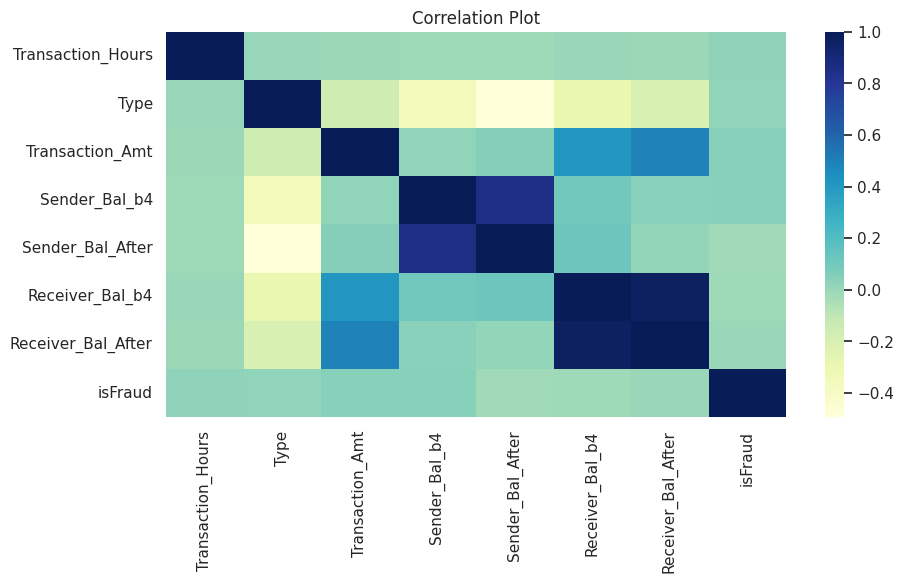

In [ ]:
#Correlation Plot
plt.figure(figsize=(10,5))
plt.title("Correlation Plot")
sns.heatmap(df_updated.corr(),cmap="YlGnBu")

In [ ]:
#Calculate the correlation matrix
correlation_matrix=df_updated.corr()

#Create a mask to identify the features with a correlation coefficient greater than or equal to 0.75
high_correlation_mask=correlation_matrix>=0.85

#Identify and list the highly correlated features
highly_correlated_features=[]

for feature in high_correlation_mask.columns:
    correlated_with=high_correlation_mask.index[high_correlation_mask[feature]].tolist()
    for correlated_feature in correlated_with:
        if feature!=correlated_feature and (correlated_feature,feature) not in highly_correlated_features:
            highly_correlated_features.append((feature,correlated_feature))

print("Highly correlated features:")
for feature1,feature2 in highly_correlated_features:
    print(f"{feature1} and {feature2}")

Highly correlated features:
Sender_Bal_b4 and Sender_Bal_After
Receiver_Bal_b4 and Receiver_Bal_After


In [17]:
#Splitting the data set into dependent and independent variables
x=df_updated.drop(["isFraud"],axis=1)
y=df_updated["isFraud"]

#2.How did you select variables to be included in the model?
1.Principal Component Analysis (PCA) and Dimensionality Reduction

2.Feature Importance with Tree-Based Model: Train a Random Forest model and use the built-in feature importance to rank variables, helping you keep the most significant ones.

In [ ]:
#Checking Feature Importance
discrete_features=x.dtypes == int
def mi_score_maker(x,y,discreate_features):
    scores=mutual_info_regression(x,y,discrete_features=discreate_features)
    df=pd.DataFrame({
        "Features":x.columns,
        "Scores":scores
    })
    df=df.sort_values(["Scores"],ascending=False).reset_index(drop=True)
    return df

In [ ]:
mi_scores=mi_score_maker(x,y.astype("float64"),discrete_features)
mi_scores

,Features,Scores
0,Transaction_Hours,0.003830
1,Transaction_Amt,0.001846
2,Sender_Bal_b4,0.001382
3,Type,0.001016
4,Sender_Bal_After,0.001003
5,Receiver_Bal_After,0.000177
6,Receiver_Bal_b4,0.000048


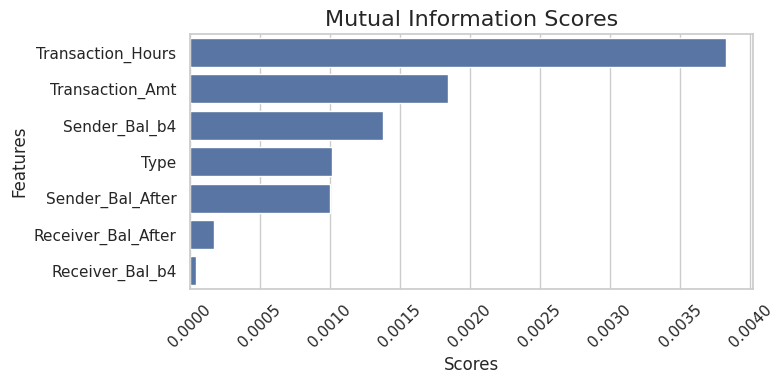

In [ ]:
plt.figure(figsize=(8,4))

#Create the barplot
sns.barplot(x="Scores",y="Features",data=mi_scores)

#Add a title
plt.title("Mutual Information Scores",fontsize=16)

#Rotate the y-axis labels(if needed)
plt.yticks(rotation=0)

#Rotate the x-axis labels (if needed)
plt.xticks(rotation=45)

#Display the plot
plt.tight_layout()
plt.show()

In [90]:
#Feature Scaling
scaler=StandardScaler()
x_scaled=scaler.fit_transform(x)

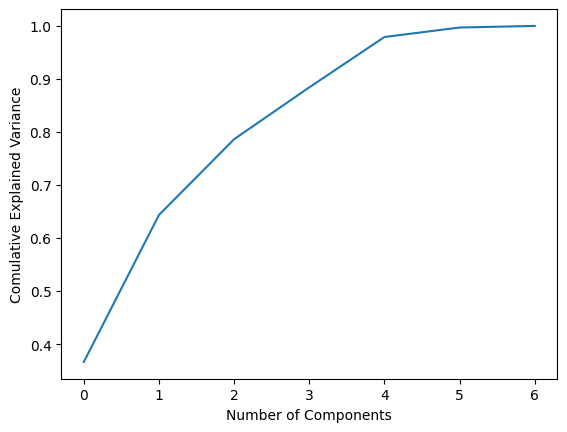

In [91]:
#Implement PCA
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(x_scaled)
explained_variance_ratio=pca.explained_variance_ratio_
commulative_variance_ratio=explained_variance_ratio.cumsum()

plt.plot(commulative_variance_ratio)
plt.xlabel("Number of Components")
plt.ylabel("Comulative Explained Variance")
plt.show()

In [92]:
##PCA-Transformation
pca=PCA(n_components=6)
pca

PCA(n_components=6)

In [93]:
#Scaled Data
x_scaled=pca.fit_transform(x_scaled)

# 3.Modeling : Describe your fraud detection model in elaboration.

In [18]:
#Divide the dataset into training and testing
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
x_train_scaled,x_test_scaled,y_train,y_test=train_test_split(x_scaled,y,test_size=0.2,random_state=42)

In [19]:
#Model Evaluation Metrics
from sklearn.metrics import(
accuracy_score,
recall_score,
precision_score,
f1_score,
confusion_matrix,classification_report,
roc_auc_score,
roc_curve,
)

In [20]:
#Library for Cross-Validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold,cross_val_score,cross_val_predict,RandomizedSearchCV

In [21]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=13)


##Without Random Sampling

In [ ]:
score = cross_val_score(rf, x_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.73692191 0.73672231 0.75493171 0.75132676 0.74677786]
Average Cross Validation Recall score: 0.7453361112996579


##4.Demonstrate the performance of the model by using best set of tools:

** Evaluation Metrics for Fraud Detection:**

**AUC-ROC Curve (Area Under the Receiver Operating Characteristic Curve)**: This metric provides a single measure that summarizes the model's ability to distinguish between fraud and non-fraud. It's particularly useful when dealing with imbalanced datasets.

**Precision, Recall, and F1 Score:** Fraud detection often requires a high recall to minimize false negatives (missed frauds) and a good balance with precision to avoid too many false positives. The F1 score, as a harmonic mean of precision and recall, provides a single indicator of performance.

**Confusion Matrix:** This shows the true positives, true negatives, false positives, and false negatives, providing insight into the model's performance for both classes (fraud and non-fraud).

**Precision-Recall Curve:** Especially useful in highly imbalanced datasets like fraud detection, where the number of fraudulent cases is much lower than non-fraud cases.

## Random Sampling Imbalanced Dataset
Resampling involves creating a new transformed version of the training dataset in which the selected examples have a different class distribution.

There are two main approaches to random resampling for imbalanced classification; they are oversampling and undersampling.

Random Oversampling: Randomly duplicate examples in the minority class.
Random Undersampling: Randomly delete examples in the majority class.

##SMOTE (Synthetic Minority Oversampling Technique)
SMOTE (Synthetic Minority Oversampling Technique) synthesize elements for the minority class. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [32]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
ros = RandomOverSampler(random_state=42)

In [33]:
# fit and apply the transform
X_over, y_over = ros.fit_resample(x_train, y_train)

In [102]:
print('Genuine:', y_over.value_counts()[0], '/', round(y_over.value_counts()[0]/len(y_over) * 100,2), '% of the dataset')
print('Frauds:', y_over.value_counts()[1], '/',round(y_over.value_counts()[1]/len(y_over) * 100,2), '% of the dataset')

Genuine: 5083503 / 50.0 % of the dataset
Frauds: 5083503 / 50.0 % of the dataset


In [34]:
#Training Model
from imblearn.pipeline import Pipeline, make_pipeline

random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42),
                              RandomForestClassifier(n_estimators=100, random_state=13))
#cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)

In [104]:
from imblearn.over_sampling import SMOTE

smote_pipeline = make_pipeline(SMOTE(random_state=42),
                              RandomForestClassifier(n_estimators=10, random_state=13))
#cross_val_score(smote_pipeline, X_train, y_train, scoring='recall', cv=kf)

In [106]:
score2 = cross_val_score(smote_pipeline, x_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score2))
print("Average Cross Validation Recall score: {}".format(score2.mean()))

Cross Validation Recall Scores are: [0.87869598 0.88543247 0.90288316 0.88855193 0.89006823]
Average Cross Validation Recall score: 0.8891263556678911


##GridSearchCV

In [26]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [10, 20],
    'max_depth': [4, 6, 10, 12],
    'random_state': [13]
}


In [109]:
#Training Model:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
smote_rf = GridSearchCV(smote_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
smote_rf.fit(x_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_estimators=10,
                                                               random_state=13))]),
             param_grid={'randomforestclassifier__max_depth': [4, 6, 10, 12],
                         'randomforestclassifier__n_estimators': [10, 20],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='recall')

In [110]:
print('Best parameters:', smote_rf.best_params_)
print('Best score:', smote_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 20, 'randomforestclassifier__random_state': 13}
Best score: 0.9849842560177444


In [111]:
y_pred = smote_rf.best_estimator_.named_steps['randomforestclassifier'].predict(x_test)

##Confusion Matrix

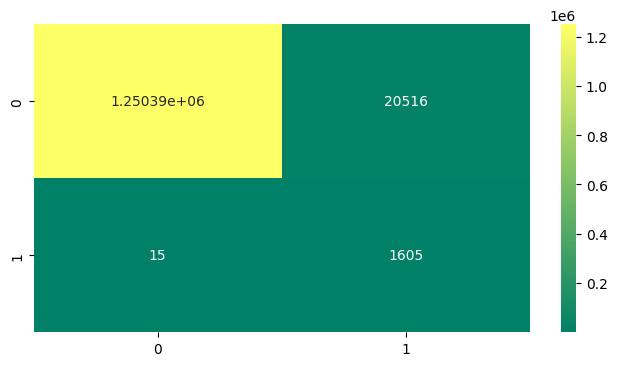

In [114]:
cm = confusion_matrix(y_test, y_pred)

smote_rf_Recall = recall_score(y_test, y_pred)
smote_rf_Precision = precision_score(y_test, y_pred)
smote_rf_f1 = f1_score(y_test, y_pred)
smote_rf_accuracy = accuracy_score(y_test, y_pred)

plt.figure(figsize=(8,4))
sns.heatmap(cm,annot=True,fmt="g",cmap="summer")
plt.show()

In [113]:
ndf = [(smote_rf_Recall, smote_rf_Precision, smote_rf_f1, smote_rf_accuracy)]

smote_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
smote_rf_score.insert(0, 'Random Forest with', 'SMOTE Oversampling')
smote_rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,SMOTE Oversampling,0.990741,0.072555,0.135209,0.983866


##3.2 Undersampling using Tomek Links
Tomek Links is an under-sampling technique that was developed in 1976 by Ivan Tomek. It is one of a modification from Condensed Nearest Neighbors (CNN). It can be used to find desired samples of data from the majority class that is having the lowest Euclidean distance with the minority class data and then remove it.

In [30]:
from imblearn.under_sampling import TomekLinks

# define the undersampling method
#tomekU = TomekLinks(sampling_strategy='auto', n_jobs=-1)
tomekU = TomekLinks()

# fit and apply the transform
X_underT, y_underT = tomekU.fit_resample(x_train, y_train)

In [31]:
print('Genuine:', y_underT.value_counts()[0], '/', round(y_underT.value_counts()[0]/len(y_underT) * 100,2), '% of the dataset')
print('Frauds:', y_underT.value_counts()[1], '/',round(y_underT.value_counts()[1]/len(y_underT) * 100,2), '% of the dataset')

Genuine: 5081998 / 99.87 % of the dataset
Frauds: 6593 / 0.13 % of the dataset


##3.3 Combining SMOTE and Tomek Links
A combination of over-sampling the minority (abnormal) class and under-sampling the majority (normal) class can achieve better classifier performance than only under-sampling the majority class. This method was first introduced by Batista et al. (2003).

The process of SMOTE-Tomek Links is as follows.

Start of SMOTE: choose random data from the minority class.
Calculate the distance between the random data and its k nearest neighbors.
Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
Repeat step number 2–3 until the desired proportion of minority class is met (End of SMOTE).
Start of Tomek Links: choose random data from the majority class.
If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.

In [35]:
#Training Model
from imblearn.combine import SMOTETomek

SMOTETomek_pipeline = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')),
                              RandomForestClassifier(n_estimators=10, random_state=13))
#cross_val_score(smote_pipeline, X_train, y_train, scoring='recall', cv=kf)

## GridSearchCV
GridSearchCV combined with SMOTE-Tomek and k-fold Cross-Validation is computationally very demanding. It takes more than 12 hours and that's time consuming.


In [36]:
SMOTETomek_rf = SMOTETomek_pipeline
SMOTETomek_rf.fit(x_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=10, random_state=13))])

##Cofusion Matrix

In [37]:
y_pred = SMOTETomek_rf.predict(x_test)

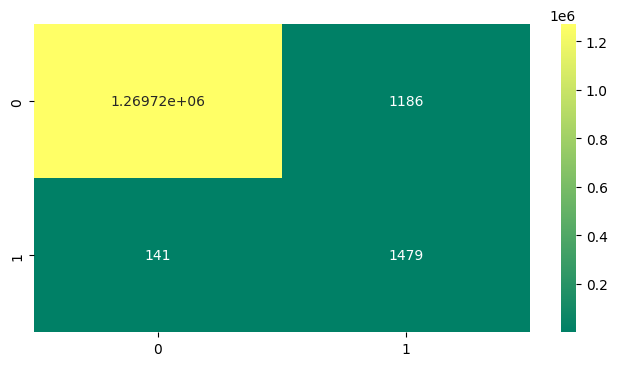

In [38]:

cm = confusion_matrix(y_test, y_pred)

SMOTETomek_rf_Recall = recall_score(y_test, y_pred)
SMOTETomek_rf_Precision = precision_score(y_test, y_pred)
SMOTETomek_rf_f1 = f1_score(y_test, y_pred)
SMOTETomek_rf_accuracy = accuracy_score(y_test, y_pred)

plt.figure(figsize=(8,4))
sns.heatmap(cm,annot=True,fmt="g",cmap="summer")
plt.show()

In [39]:
ndf = [(SMOTETomek_rf_Recall, SMOTETomek_rf_Precision, SMOTETomek_rf_f1, SMOTETomek_rf_accuracy)]

SMOTETomek_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
SMOTETomek_rf_score.insert(0, 'Random Forest with', 'SMOTE + Tomek')
SMOTETomek_rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,SMOTE + Tomek,0.912963,0.554972,0.690315,0.998957


##ROC and AUC Curve
AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve.

ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.

An excellent model has AUC near to the 1 which means it has a good measure of separability. A poor model has an AUC near 0 which means it has the worst measure of separability.

In [116]:
from sklearn.metrics import roc_auc_score
ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for Random Forest with Class weights: {ROCAUCscore:.4f}")

AUC-ROC Curve for Random Forest with Class weights: 0.9873


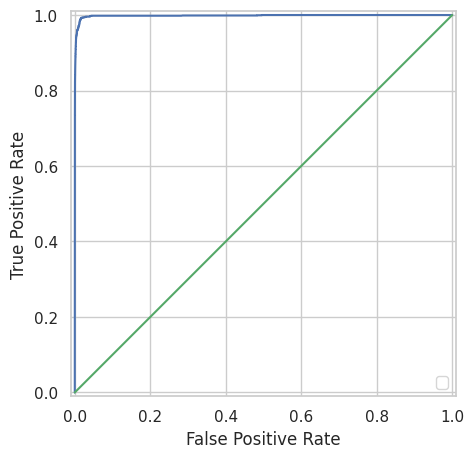

In [118]:
y_proba = smote_rf.predict_proba(x_test)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
# Plots the ROC curve using the sklearn methods - Good plot
plot_auc_roc_curve(y_test, y_proba[:, 1])
# Plots the ROC curve using the sklearn methods - Bad plot
#plot_sklearn_roc_curve(y_test, y_pred)

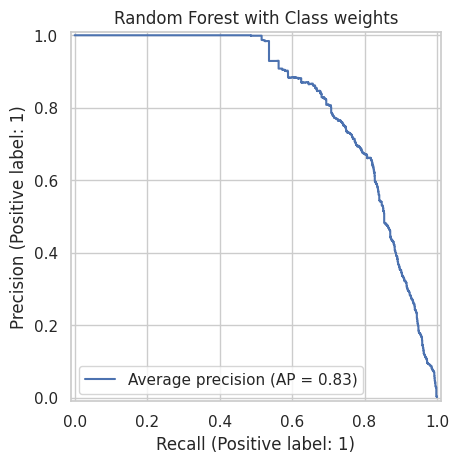

In [119]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    smote_rf, x_test, y_test, name="Average precision")
_ = display.ax_.set_title("Random Forest with Class weights")

#5.What are the key factors that predict fraudulent customer?

1. **Transaction Amount**
Abnormally High or Low Amounts: Transactions that deviate significantly from the customer’s normal spending patterns can be suspicious. For example, a sudden large transaction from an account that typically has low transaction amounts could indicate fraud.

2. **Transaction Hours**

 Unusual Times: Transactions occurring at odd hours, such as late at night or early morning, may indicate fraudulent behavior. Fraudsters often attempt transactions during non-business hours to avoid detection.

3. **Transaction Type**
High-Risk Transaction Types: Certain transaction types are more prone to fraud, such as international transfers, online purchases, or wire transfers. For example, international transactions are often riskier than local payments.

## 6.What kind of prevention should be adopted while company update its infrastructure?

1. **Risk Assessment and Planning**
Conduct a Comprehensive Risk Assessment: Identify the risks associated with the infrastructure update, including potential vulnerabilities in the new systems, compatibility issues, and the impact on current operations.

2. **Data Backup and Recovery Measures**
Perform Full Backups: Ensure that all critical data and configurations are backed up before the update begins. This includes databases, application files, server configurations, and system images.

Test Backup and Recovery Processes: Verify that backups are functional and recovery processes work smoothly, allowing quick restoration if any data loss or corruption occurs during the update.

3. **Security Precautions**
Patch and Update Security Software: Ensure all security tools, such as antivirus, firewalls, and intrusion detection/prevention systems, are updated and fully operational.

4. **Continuous Monitoring**
Enable Real-Time Monitoring: Track key metrics such as network traffic, server load, application performance, and security alerts in real-time to detect issues as they arise.

#7.Assuming these actions have been implemented, how would you determine if they work?

1. **Real-Time Monitoring and Alerting**
Analyze System Logs and Alerts: Review logs from servers, applications, and network devices. Automated alerts should be in place for any unusual activity, such as spikes in traffic, CPU usage, or unauthorized access attempts. Investigate alerts to ensure they’re flagging genuine issues.

  Monitor Key Metrics: Continuously monitor performance metrics like response times, server loads, and error rates. Any deviation from the norm could indicate issues with the updated infrastructure. For instance, higher-than-expected error rates might signal a compatibility problem.

  Check Security Logs: Examine security logs for unusual patterns, such as failed login attempts or new device connections. This helps verify whether access controls and security policies are effective in preventing unauthorized access.

2. **Regular Review and Continuous Improvement**
Schedule Regular Reviews: Conduct periodic reviews of the update's impact on infrastructure performance and security. This allows for ongoing assessment and optimization.
Update Documentation: Ensure that all preventive actions and outcomes are documented. This provides a clear record of what was done and helps in troubleshooting any issues that arise later.